<a href="https://colab.research.google.com/github/gusti-amber/udemy_pytorch/blob/main/lecture/lec5_simple_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# シンプルなCNNの実装
PyTorchによりシンプルな再帰型ニューラルネットワーク（RNN）を実装する。

RNNにノイズ付きサインカーブを学習させて、1つ先の未来を予測することによる曲線の描画を行う。

# 1. 訓練用データの作成
サインカーブに乱数でノイズを加えてRNNに用いる訓練用のデータを作成する。

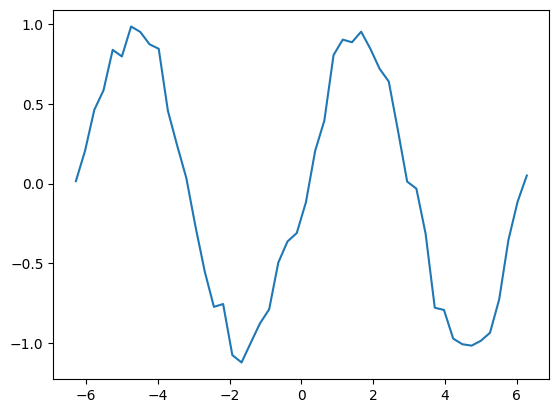

In [1]:
import numpy as np
import matplotlib.pyplot as plt

sin_x = np.linspace(-2*np.pi, 2*np.pi)  # x: -2π~2π
sin_y = np.sin(sin_x) + 0.1*np.random.randn(len(sin_x))  # y=sin(x), さらにノイズを加える
plt.plot(sin_x, sin_y)
plt.show()

# 2. データの前処理
入力、正解データをRNNに適した形に整える。
時系列から次の値を予測できるように、時系列を入力として正解はその1つ後の値とします。

In [3]:
import torch
from torch.utils.data import DataLoader

n_time = 10 # 入力で使う時系列の数
n_sample = len(sin_x)-n_time # サンプル数

# データの初期化
input_data = np.zeros((n_sample, n_time, 1)) # 入力: 時系列10のデータ
correct_data = np.zeros((n_sample, 1)) # 正解: 1つのデータ

for i in range(n_sample):
  input_data[i] = sin_y[i:i+n_time].reshape(-1,1) # tips: 列ベクトルに変換
  correct_data[i] = sin_y[i+n_time:i+n_time+1] # 正解は入力データの1つ先

# データのテンソル化
input_data = torch.tensor(input_data, dtype=torch.float)
correct_data = torch.tensor(correct_data, dtype=torch.float)

# カスタムデータセットの作成
dataset = torch.utils.data.TensorDataset(input_data, correct_data)

# DataLoaderの設定
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

# 3. モデルの構築
nn.Moduleモジュールを継承したクラスとしてモデルを構築する。
RNNはnn.RNNを使って実装できる。

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.rnn = nn.RNN( # RNN層
        input_size=1, # 入力サイズ
        hidden_size=64, # ニューロン数
        batch_first=True # 入力:(バッチサイズ, 時系列の数, 入力の数)に設定
    )
    self.fc = nn.Linear(64,1) # 全結合層

  def forward(self, x):
    y_rnn, h = self.rnn(x, None)
    y = self.fc(y_rnn[:,-1,:])
    return y

net = Net()
print(net)

Net(
  (rnn): RNN(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


# 4. モデルの学習
DataLoaderを使い、ミニバッチを取り出して訓練および評価を行う。

訓練したモデルを使い、直近の時系列を使った予測結果を次々と時系列に加えていくことにより、曲線が生成される。

学習が進むとともに次第にサインカーブが生成されるようになりるが、曲線は一定のエポック間隔でグラフとして描画される。

Epoch: 0 Loss_Train: 0.5449463367462158


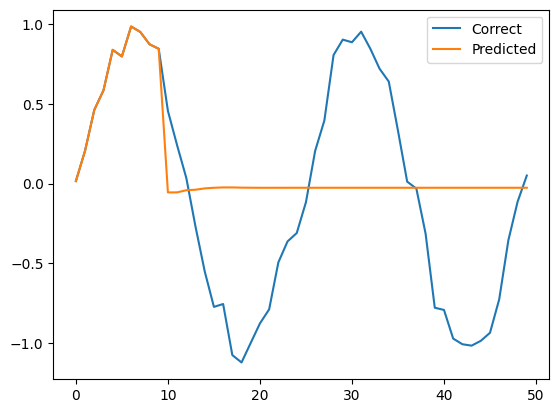

Epoch: 2 Loss_Train: 0.3993403255939484


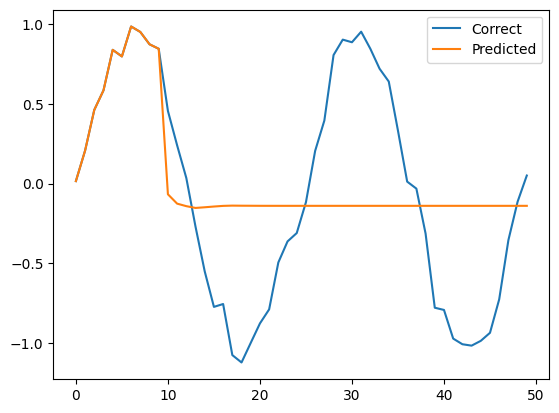

Epoch: 4 Loss_Train: 0.3231430292129517


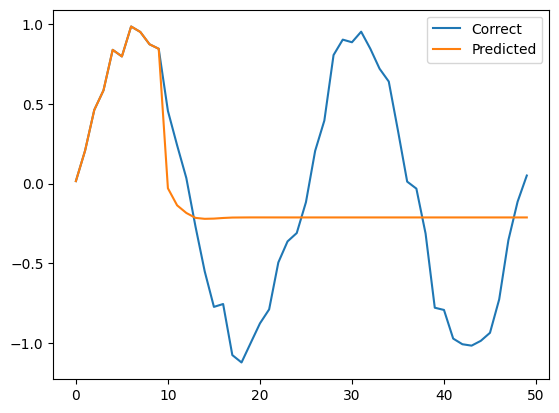

Epoch: 6 Loss_Train: 0.2607597216963768


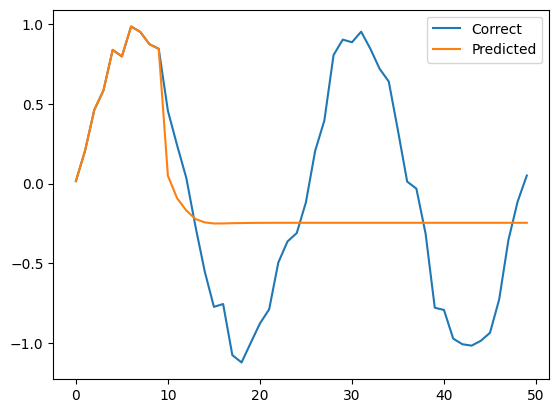

Epoch: 8 Loss_Train: 0.2125440090894699


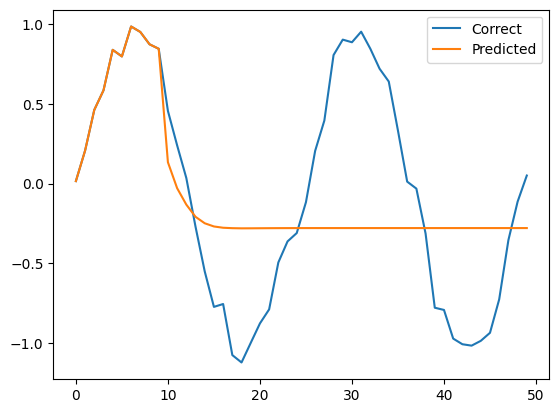

Epoch: 10 Loss_Train: 0.17448419332504272


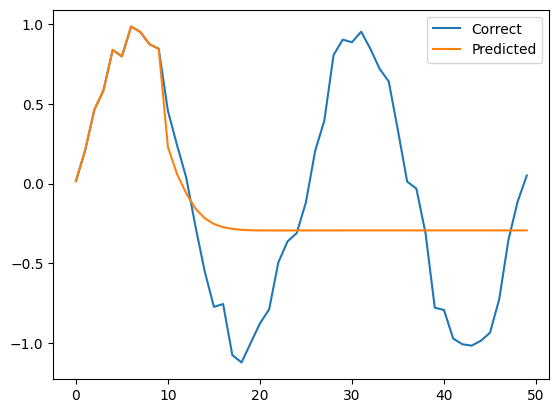

Epoch: 12 Loss_Train: 0.1450982376933098


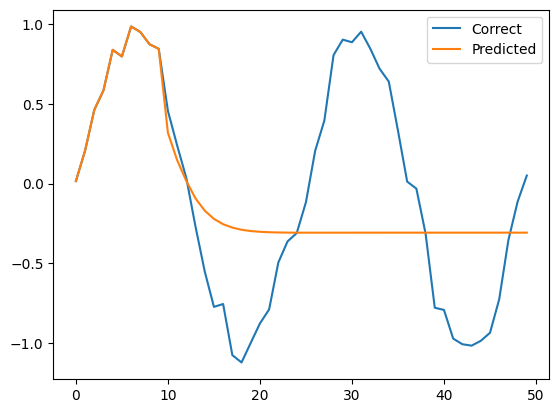

Epoch: 14 Loss_Train: 0.12088703960180283


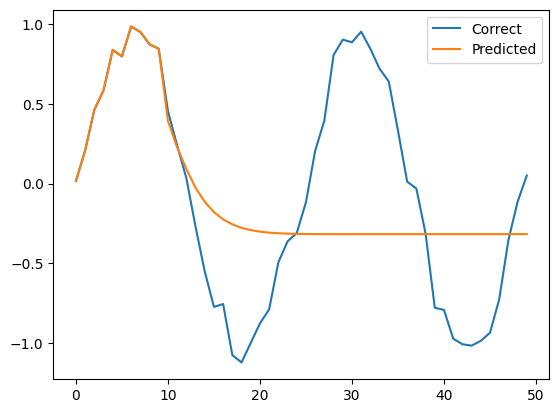

Epoch: 16 Loss_Train: 0.1050697349011898


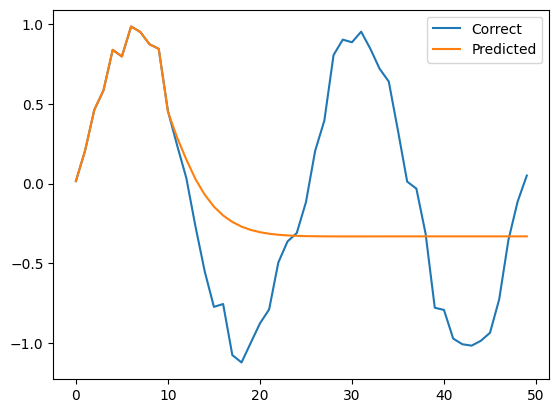

Epoch: 18 Loss_Train: 0.09161478504538537


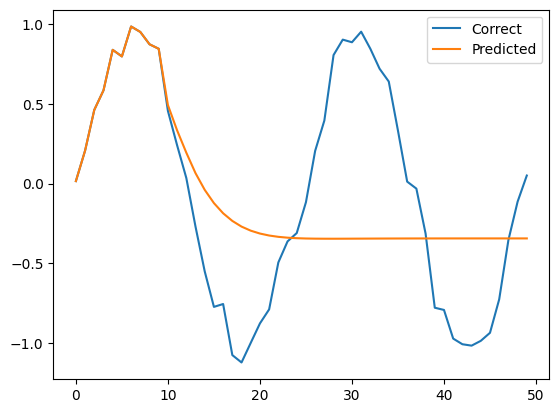

Epoch: 20 Loss_Train: 0.08003403469920159


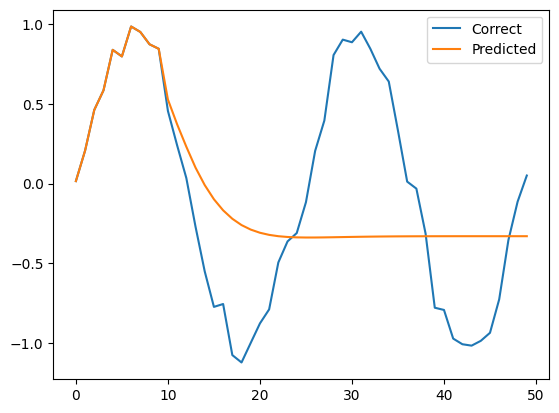

Epoch: 22 Loss_Train: 0.07031759917736054


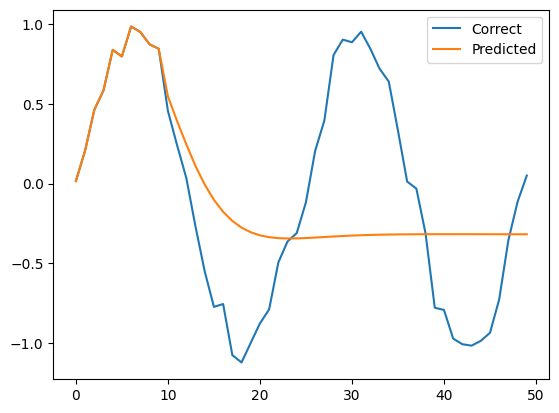

Epoch: 24 Loss_Train: 0.0614728931337595


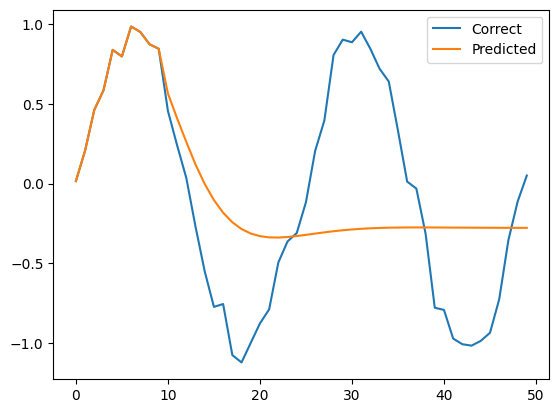

Epoch: 26 Loss_Train: 0.05207521133124828


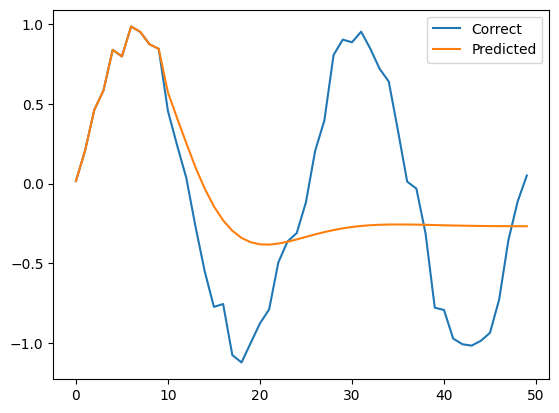

Epoch: 28 Loss_Train: 0.04314591698348522


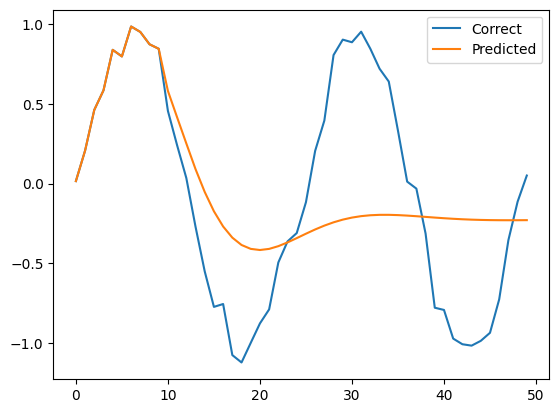

Epoch: 30 Loss_Train: 0.03498584553599358


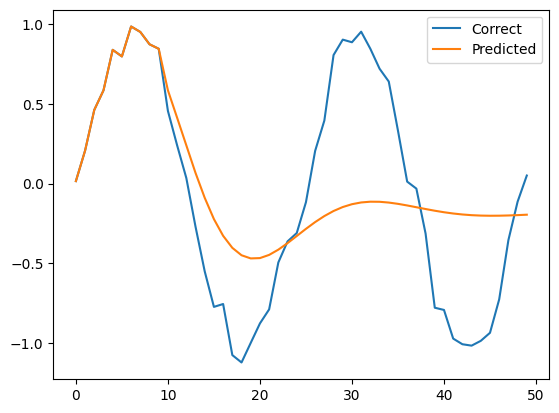

Epoch: 32 Loss_Train: 0.02771204076707363


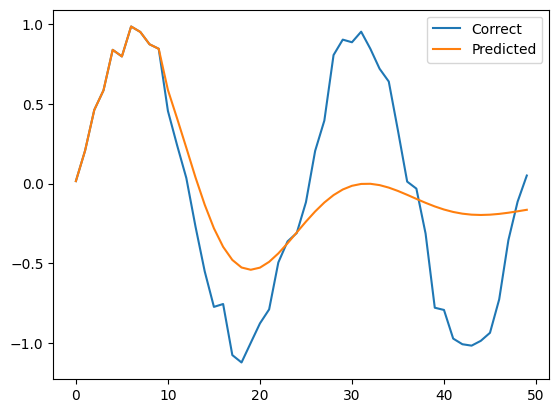

Epoch: 34 Loss_Train: 0.021633973345160484


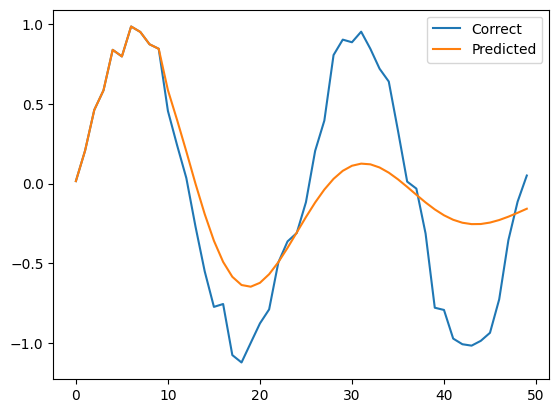

Epoch: 36 Loss_Train: 0.01699880324304104


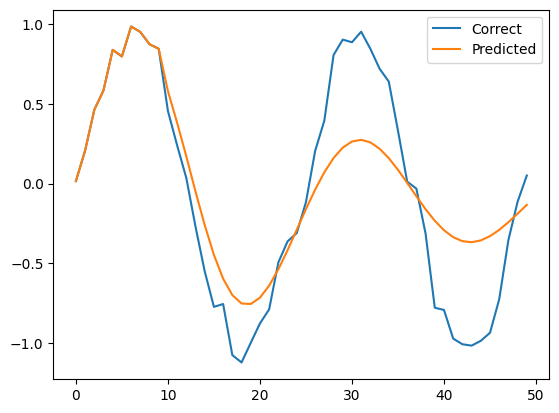

Epoch: 38 Loss_Train: 0.014138469751924277


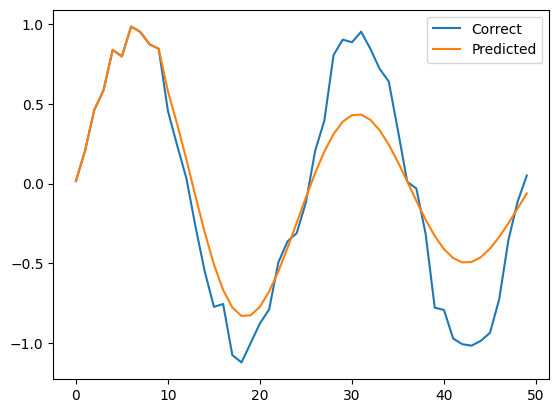

Epoch: 40 Loss_Train: 0.012108606658875943


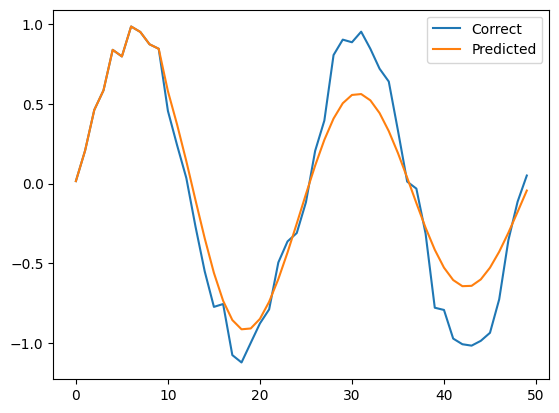

Epoch: 42 Loss_Train: 0.011162392795085907


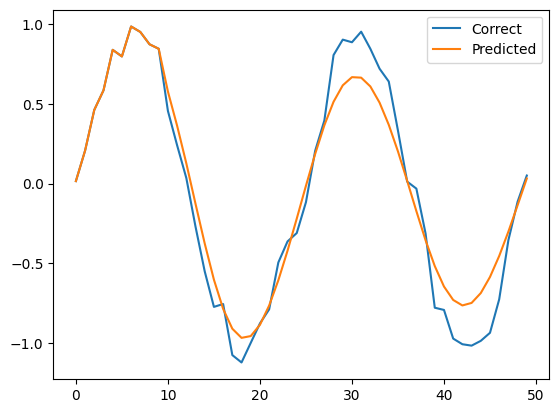

Epoch: 44 Loss_Train: 0.010752790980041027


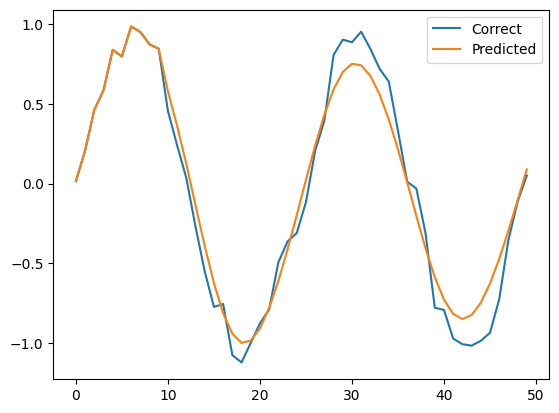

Epoch: 46 Loss_Train: 0.010527336038649082


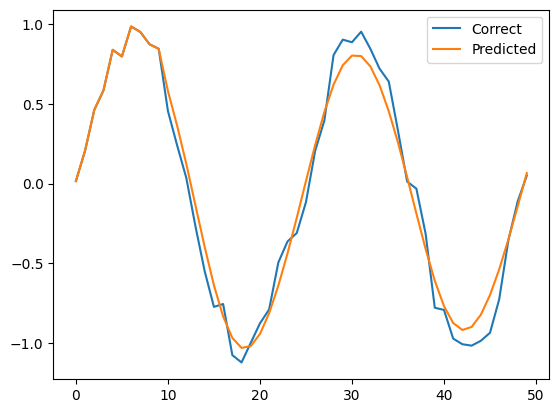

Epoch: 48 Loss_Train: 0.010390090383589267


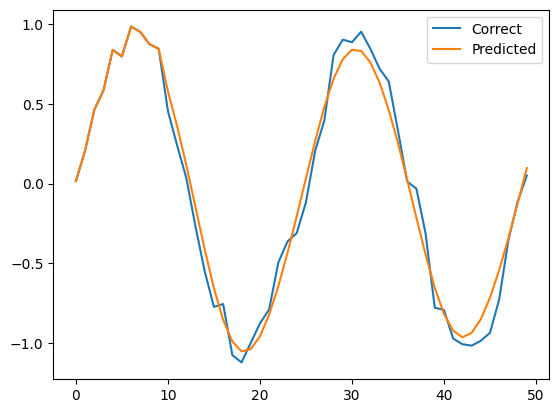

In [7]:
from torch import optim

# 誤差関数: 平均二乗誤差関数
loss_fnc = nn.MSELoss()

# 最適化アルゴリズム: SGD
optimizer = optim.SGD(net.parameters(), lr=0.01)

# 損失ログ
record_loss_train = []

# 学習
for i in range(50):  # 50エポック
    # 訓練
    net.train()
    loss_train = 0
    for j, (x, t) in enumerate(train_loader):
        # 順伝播
        y = net(x)
        loss = loss_fnc(y, t)
        loss_train += loss.item()

        # 逆伝播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_train /= j+1
    record_loss_train.append(loss_train)

    if i%2 == 0:
      print("Epoch:", i, "Loss_Train:", loss_train)

      # 予測カーブの点群の作成
      predicted = list(input_data[0].reshape(-1)) # 2次元配列(10,1)から1次元配列(10,)に変換

      for i in range(n_sample):
        x = torch.tensor(predicted[-n_time:]) # 末尾から10個分のデータを取得
        x = x.reshape(1,n_time,1) # 1次元配列(10,1)から3次元配列(1,10,1)に変換
        y = net(x)
        predicted.append(y[0].item())

      # 予測カーブの表示
      plt.plot(range(len(sin_y)), sin_y, label="Correct")
      plt.plot(range(len(predicted)), predicted, label="Predicted")
      plt.legend()
      plt.show()



# 5. 誤差の推移

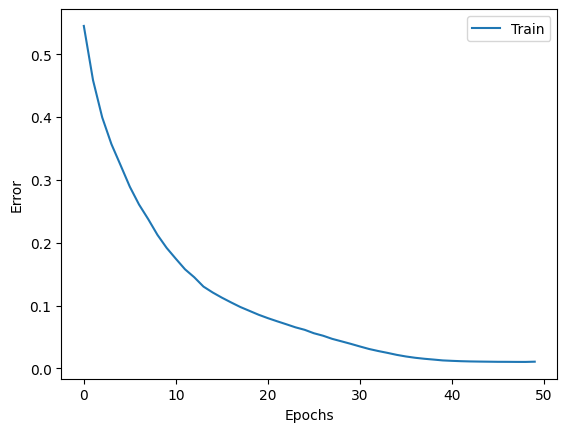

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()